In [1]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.models import Sequential

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\program files\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
def selectFeature(df):
    data = df.copy()
    
    data['Embarked'] = data['Embarked'].fillna('C')
    
    sex_label = LabelEncoder().fit(data['Sex'].unique())
    
    data['Sex_l'] = data['Sex'].map(lambda x: sex_label.transform([x])[0])
    
    pclass_dummies = pd.get_dummies(data['Pclass'], 'Pclass')
    embarked_dummies = pd.get_dummies(data['Embarked'], 'Embarked')
    
    data = data.join(pclass_dummies, how='inner')
    data = data.join(embarked_dummies, how='inner')
    
    family_tickets = data.groupby('Ticket').filter(lambda x: len(x) > 1)['Ticket'].values
    data['Family'] = data['Ticket'].map(lambda x: x in family_tickets).astype(int)
    
    data['Age_1'] = data['Age'].map(lambda x: int(x < 10.) & (x >= 0.))
    data['Age_2'] = data['Age'].map(lambda x: int(x < 20.) & (x >= 10.))
    data['Age_3'] = data['Age'].map(lambda x: int(x < 30.) & (x >= 20.))
    data['Age_4'] = data['Age'].map(lambda x: int(x < 40.) & (x >= 30.))
    data['Age_5'] = data['Age'].map(lambda x: int(x < 50.) & (x >= 40.))
    data['Age_6'] = data['Age'].map(lambda x: int(x < 60.) & (x >= 50.))
    data['Age_7'] = data['Age'].map(lambda x: int(x < 70.) & (x >= 60.))
    data['Age_8'] = data['Age'].map(lambda x: int(x >= 80.))
    
    data = data.drop(['Ticket', 'Cabin', 'Name', 'Embarked', 'Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'], axis=1)
    data = data.fillna(0)
        
    return data

In [5]:
train = selectFeature(train_df)
test = selectFeature(test_df)

In [6]:
# for cnn
X_train = np.expand_dims(train.values[:, 2:], axis=2)

In [7]:
# for dnn
X_train = train.values[:, 2:]

In [8]:
Y_train = pd.get_dummies(train.Survived).values
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [9]:
def cnn(x, y):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, padding='same', activation='relu', input_shape=x.shape[1:]))
    model.add(MaxPooling1D())
    model.add(Conv1D(32, kernel_size=5, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling1D())
    model.add(Conv1D(32, kernel_size=5, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling1D())
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=keras.optimizers.adam(lr=0.0002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [44]:
def dnn(x, y):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=x.shape[1:]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=keras.optimizers.adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [45]:
model = dnn(X_train, Y_train)
X_train.shape, Y_train.shape

((891, 16), (891, 2))

In [46]:
hist = model.fit(X_train, Y_train, batch_size=50, epochs=50, validation_split=0.2)

Train on 712 samples, validate on 179 samples
Epoch 1/50
712/712 [==============================] - 1s 773us/step - loss: 0.6863 - categorical_accuracy: 0.6011 - val_loss: 0.6785 - val_categorical_accuracy: 0.6536
Epoch 2/50
712/712 [==============================] - 0s 38us/step - loss: 0.6757 - categorical_accuracy: 0.6208 - val_loss: 0.6667 - val_categorical_accuracy: 0.6480
Epoch 3/50
712/712 [==============================] - 0s 39us/step - loss: 0.6653 - categorical_accuracy: 0.6208 - val_loss: 0.6530 - val_categorical_accuracy: 0.6480
Epoch 4/50
712/712 [==============================] - 0s 42us/step - loss: 0.6537 - categorical_accuracy: 0.6208 - val_loss: 0.6407 - val_categorical_accuracy: 0.6480
Epoch 5/50
712/712 [==============================] - 0s 48us/step - loss: 0.6416 - categorical_accuracy: 0.6208 - val_loss: 0.6256 - val_categorical_accuracy: 0.6480
Epoch 6/50
712/712 [==============================] - 0s 42us/step - loss: 0.6288 - categorical_accuracy: 0.6124 - val

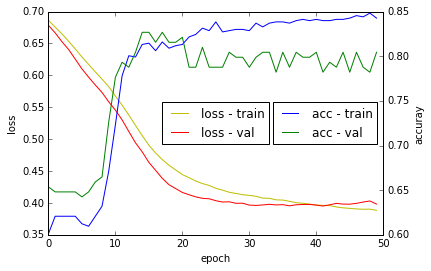

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='loss - train')
loss_ax.plot(hist.history['val_loss'], 'r', label='loss - val')

acc_ax.plot(hist.history['categorical_accuracy'], 'b', label='acc - train')
acc_ax.plot(hist.history['val_categorical_accuracy'], 'g', label='acc - val')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')

plt.show()

In [13]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    #'Survived': model.predict_classes(np.expand_dims(test.values[:, 1:], axis=2)).flatten()
    'Survived': model.predict_classes(test.values[:, 1:]).flatten()
})

In [14]:
submission.to_csv('lr_submission.csv', index=False)